# LSTM for Human Activity Recognition

Human activity recognition using smartphones sata set and an LSTM ANN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.


## Video dataset overview

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="400" height="300" border="10" /></a>


## Details

I will be using an LSTM on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing.

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.


## Results 

Scroll ! Nice visuals awaits. 

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell
from sklearn import metrics

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


## Let's start by downloading the data: 

In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Data set is now located at: " + DATASET_PATH)


/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition
data		       LSTM (another copy).ipynb  LSTM.ipynb
Feedforward ANN.ipynb  LSTM (copy).ipynb	  README.md
LSTM (3rd copy).ipynb  LSTM_files		  Untitled.ipynb
/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip
/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition
data		       LSTM (another copy).ipynb  LSTM.ipynb
Feedforward ANN.ipynb  LSTM (copy).ipynb	  README.md
LSTM (3rd copy).ipynb  LSTM_files		  Untitled.ipynb

Data set is now located at: data/UCI HAR Dataset/


## Preparing dataset:

In [4]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'rb')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'rb')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [5]:

# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 28 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0015
training_iters = training_data_count * 100  # Loop 100 times on the dataset, for a total of 7352000 iterations
batch_size = 1500
display_iter = 15000  # To show test set accuracy during training


# Some debugging info

print "Some useful info to get an insight on dataset's shape and normalisation:"
print "(X shape, y shape, every X's mean, every X's standard deviation)"
print (X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print "The dataset is therefore properly normalised, as expected, but not yet one-hot encoded."


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
((2947, 128, 9), (2947, 1), 0.099139921, 0.39567086)
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [6]:
def LSTM_RNN(_X, _istate, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Note, some code of this notebook is inspired from an slightly different 
    # ANN architecture used on another dataset: 
    # https://tensorhub.com/aymericdamien/tensorflow-rnn

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']
    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, _X, initial_state=_istate)

    # Linear activation
    # Get inner loop last output
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Let's get serious and build the neural network:

In [7]:

# Graph input/output
x = tf.placeholder("float", [None, n_steps, n_input])
istate = tf.placeholder("float", [None, 2*n_hidden]) #state & cell => 2x n_hidden
y = tf.placeholder("float", [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, istate, weights, biases)

# Loss, optimizer and evaluation
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


## Hooray, now train the neural network:

In [8]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.initialize_all_variables()
sess.run(init)

# Perform Training steps with "batch_size" iterations at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys,
            istate: np.zeros((batch_size, 2*n_hidden))
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print "Iter " + str(step*batch_size) + \
              ", Batch Loss= " + "{:.6f}".format(loss) + \
              ", Accuracy= " + "{}".format(acc)
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test),
                istate: np.zeros((len(X_test), 2*n_hidden))
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print "TEST SET DISPLAY STEP: " + \
              "Batch Loss= {}".format(loss) + \
              ", Accuracy= " + "{}".format(acc)

    step += 1

print "Optimization Finished!"

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test),
        istate: np.zeros((len(X_test), 2*n_hidden))
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print "FINAL RESULT: " + \
      "Batch Loss= {}".format(final_loss) + \
      ", Accuracy= " + "{}".format(accuracy)


Iter 1500, Batch Loss= 3.497532, Accuracy= 0.167333334684
TEST SET DISPLAY STEP: Batch Loss= 2.93614697456, Accuracy= 0.200882256031
Iter 15000, Batch Loss= 1.597702, Accuracy= 0.45666667819
TEST SET DISPLAY STEP: Batch Loss= 1.55875110626, Accuracy= 0.38581609726
Iter 30000, Batch Loss= 1.238804, Accuracy= 0.499333322048
TEST SET DISPLAY STEP: Batch Loss= 1.22680544853, Accuracy= 0.504580914974
Iter 45000, Batch Loss= 0.954462, Accuracy= 0.663999974728
TEST SET DISPLAY STEP: Batch Loss= 1.02884912491, Accuracy= 0.61418390274
Iter 60000, Batch Loss= 0.804594, Accuracy= 0.680000007153
TEST SET DISPLAY STEP: Batch Loss= 0.924499809742, Accuracy= 0.623685121536
Iter 75000, Batch Loss= 0.698102, Accuracy= 0.719333350658
TEST SET DISPLAY STEP: Batch Loss= 0.794336855412, Accuracy= 0.666779756546
Iter 90000, Batch Loss= 0.608659, Accuracy= 0.757333338261
TEST SET DISPLAY STEP: Batch Loss= 0.723006248474, Accuracy= 0.70105189085
Iter 105000, Batch Loss= 0.507658, Accuracy= 0.817333340645
TEST

## Training is good, but having visual insight is even better:

Okay, let's do it simply in the notebook for now

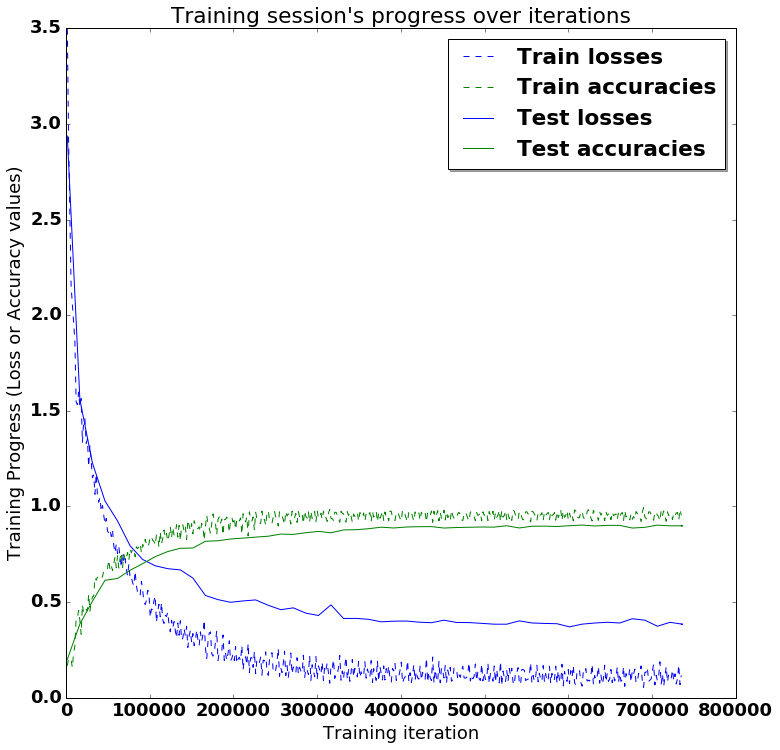

In [9]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1] + [training_iters])
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 89.8880243301%

Precision: 89.933405934%
Recall: 89.888021717%
f1_score: 89.8191732334%

Confusion Matrix:
[[453  10  33   0   0   0]
 [  1 446  24   0   0   0]
 [  6   6 408   0   0   0]
 [  1  25   0 384  81   0]
 [  1  19   1  89 422   0]
 [  0   1   0   0   0 536]]

Confusion matrix (normalised to % of total test data):
[[ 15.37156391   0.33932811   1.11978292   0.           0.           0.        ]
 [  0.03393281  15.13403511   0.8143875    0.           0.           0.        ]
 [  0.20359688   0.20359688  13.84458828   0.           0.           0.        ]
 [  0.03393281   0.84832031   0.          13.0302       2.74855804   0.        ]
 [  0.03393281   0.64472347   0.03393281   3.02002048  14.31964684   0.        ]
 [  0.           0.03393281   0.           0.           0.          18.18798828]]
Note: training and testing data is not equally distributed amongst classes, so it is normal that more than a 6th of the data is correctly classifier in the last category

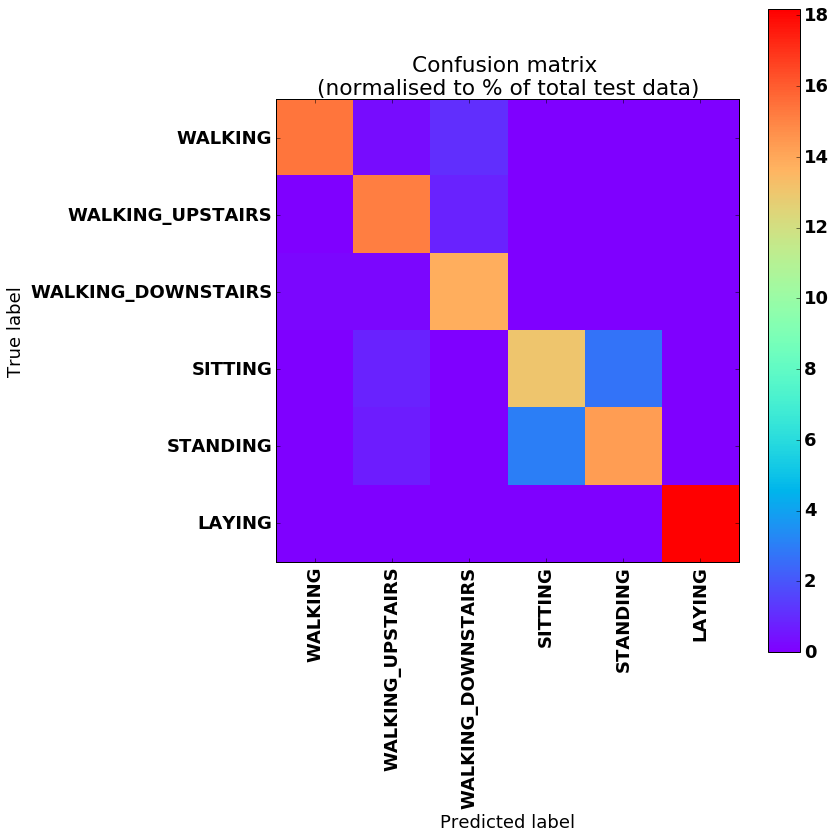

In [10]:
# Results

predictions = one_hot_predictions.argmax(1)

print "Testing Accuracy: {}%".format(100*accuracy)

print ""
print "Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted"))
print "Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted"))
print "f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted"))

print ""
print "Confusion Matrix:"
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print confusion_matrix
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print ""
print "Confusion matrix (normalised to % of total test data):"
print normalised_confusion_matrix
print ("Note: training and testing data is not equally distributed amongst classes, "
       "so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
sess.close()

## Conclusion

Outstandingly, the accuracy is of 89.888%! 

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so those predictions are extremely accurate.

I specially did not expect such good results for guessing between "WALKING" "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS" as a cellphone. Tought, it is still possible to see a little cluster on the matrix between those 3 classes. This is great.

It is also possible to see that it was hard to do the difference between "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level. 

## References

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) is described on the UCI Machine Learning Repository:

> Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

In [14]:
# Let's convert this notebook to a README as the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Support files will be in LSTM_files/
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Writing 24566 bytes to LSTM.md
